# Using NP4VTT: Local constant model

In this notebook, we show how to use a local constant model to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the local constant model, and Pandas to load the dataset:

In [15]:
import sys
sys.path.append('../src')

In [16]:
import pandas as pd
import numpy as np
from py_np4vtt.data_format import Vars
from py_np4vtt.model_lconstant import ModelLConstant, ConfigLConstant
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [17]:
df = pd.read_table('../data/Norway2009VTT_demodata.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [18]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [19]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [20]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [21]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 10.2977
Minimum of BVTT: 0.6667
Maximum of BVTT: 113.5632


## Step 3: Configure the local constant model

The local logit model requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.
* `kernelWidth`: The bandwidth of the kernel
The function `ConfigLConstant` takes the configuration parameters of the local constant model and creates an object that is used by the optimisation routine:

In [22]:
config = ConfigLConstant(minimum=0, maximum=100, supportPoints=21, kernelWidth = 2)

Now, we create the local constant model object that contains the configuration parameters and the data arrays. Then, we initialise the arguments:

In [23]:
lc = ModelLConstant(config, model_arrays)

Created a VTT grid of 21 points between 0 and 100.
Distance between points of the VTT grid is 5.0


`ModelLConstant` creates the following objects that can be accessed using the 'dot' notation (i.e., `ModelLConstant.`_object_):

* `vtt_grid`: VTT grid as specified in `ConfigLConstant`
* `vtt_mid`: VTT mid points, based in the VTT grid. The first point of the grid is zero, whereas the last point is equal to the last point of the original VTT grid.

In [24]:
vtt_grid = lc.vtt_grid
vtt_grid

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [25]:
vtt_mid = lc.vtt_mid
vtt_mid

array([  0. ,   2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,
        42.5,  47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,
        87.5,  92.5,  97.5, 100. ])

## Step 4: Estimate a local constant model

Once the local constant object is initialised, the `run` method starts the optimisation process:

In [26]:
p, vtt = lc.run()

The estimated model returns:

* `p`: The estimates of the cumulative probability function (CDF) evaluated at each mid point of the VTT grid stored in the local constant model object. The first point is always zero while the last point is always equal to the second last for compatibility with plots.
* `vtt`: The predicted VTT for each respondent, based in the probabilities of `mean_f` and the VTT grid.

The following lines present the estimated results:

In [27]:
# Create dataframe
results = pd.DataFrame(np.c_[vtt_mid,p],columns=['VTT','Cum. Prob.'],index=np.arange(len(vtt_mid)))

print('VTT distribution at each mid point of the VTT grid:')
print(results)

VTT distribution at each mid point of the VTT grid:
      VTT  Cum. Prob.
0     0.0    0.000000
1     2.5    0.187481
2     7.5    0.455846
3    12.5    0.614643
4    17.5    0.753232
5    22.5    0.812113
6    27.5    0.850271
7    32.5    0.851861
8    37.5    0.886539
9    42.5    0.908350
10   47.5    0.914379
11   52.5    0.928052
12   57.5    0.943366
13   62.5    0.926999
14   67.5    0.927135
15   72.5    0.938530
16   77.5    0.950733
17   82.5    0.939235
18   87.5    0.980716
19   92.5    0.911089
20   97.5    0.931039
21  100.0    0.931039


## Step 5: Visualising the VTT distribution

We create the empirical CDF of the VTT. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

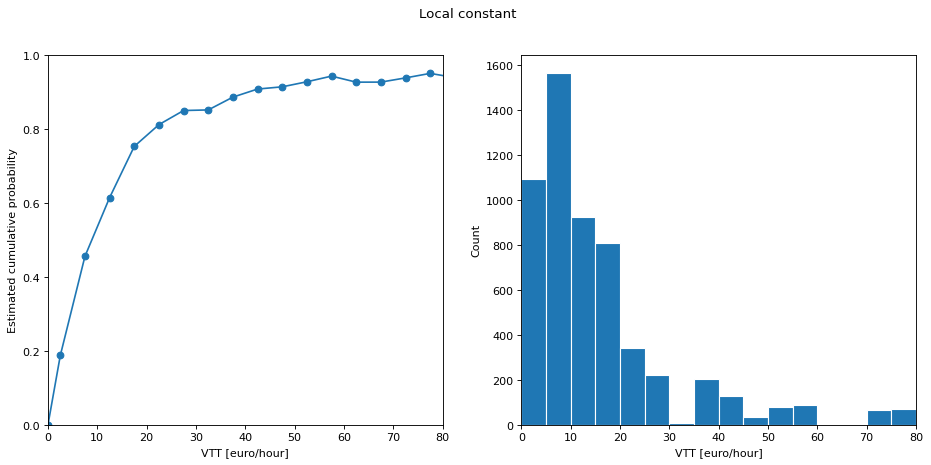

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(vtt_mid,p,marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Estimated cumulative probability')

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(vtt, bins = vtt_grid,edgecolor="white")
fig.suptitle('Local constant')
plt.savefig('outcomes/lconstant.png')
plt.show()